In [4]:
## 1. Setup and Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Pipeline and column transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [5]:
#Data Loading and Initial Exploration

# Load the data
train_df = pd.read_csv('airbnb_train.csv')
test_df = pd.read_csv('airbnb_test.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("\nTarget variable (log_price) statistics:")
print(train_df['log_price'].describe())

# Display first few rows
print("\n Display the head data of the training data:")
train_df.head()

Training data shape: (22234, 28)
Test data shape: (51877, 27)

Target variable (log_price) statistics:
count    22234.000000
mean         4.783481
std          0.718758
min          2.302585
25%          4.317488
50%          4.700480
75%          5.220356
max          7.600402
Name: log_price, dtype: float64

 Display the head data of the training data:


,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


Missing values in training data:


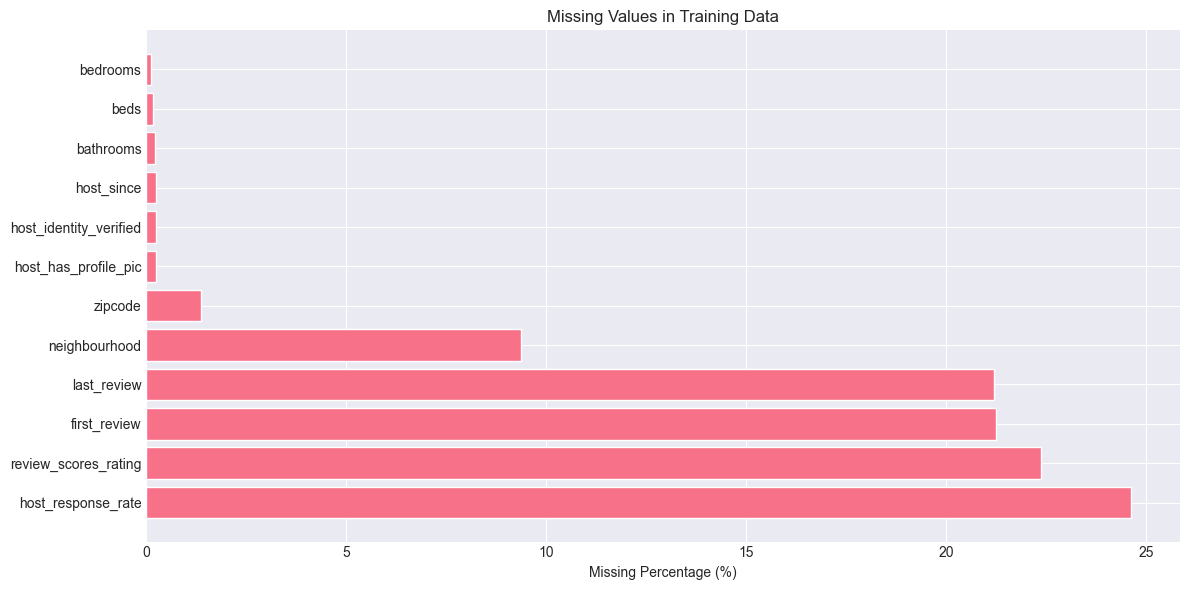

                                        Column    Dtype  Missing_Count  \
host_response_rate          host_response_rate   object           5475   
review_scores_rating      review_scores_rating  float64           4978   
first_review                      first_review   object           4725   
last_review                        last_review   object           4716   
neighbourhood                    neighbourhood   object           2086   
zipcode                                zipcode   object            303   
host_has_profile_pic      host_has_profile_pic   object             56   
host_identity_verified  host_identity_verified   object             56   
host_since                          host_since   object             56   
bathrooms                            bathrooms  float64             51   
beds                                      beds  float64             35   
bedrooms                              bedrooms  float64             26   

                        Missing_Perce

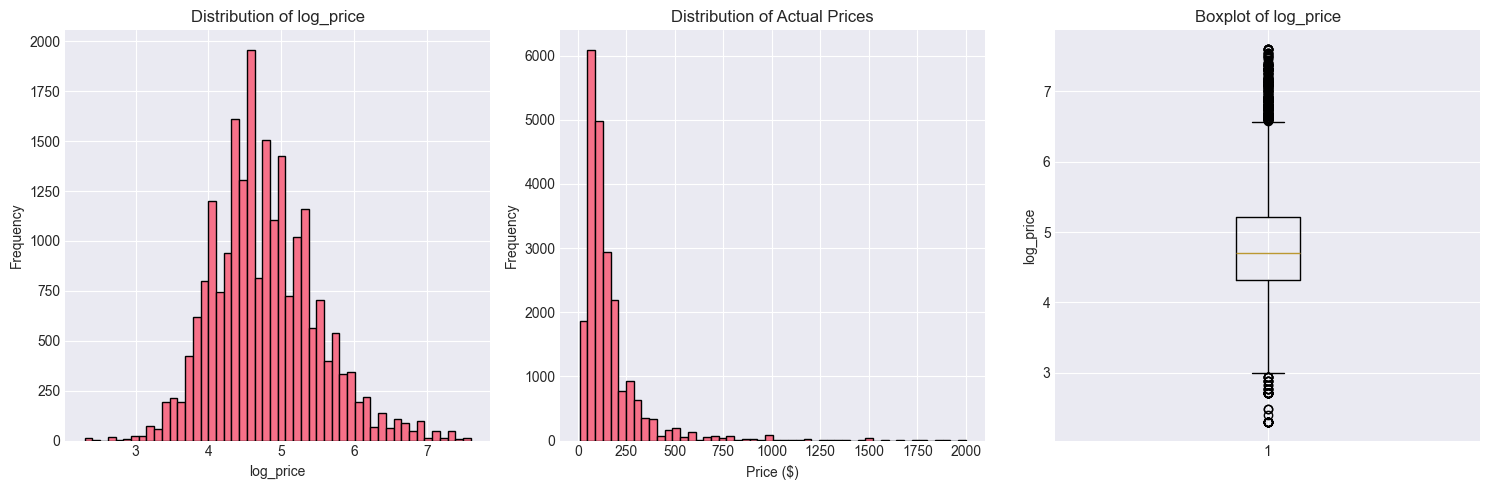

Actual price range: $10.00 - $1999.00
Median actual price: $110.00


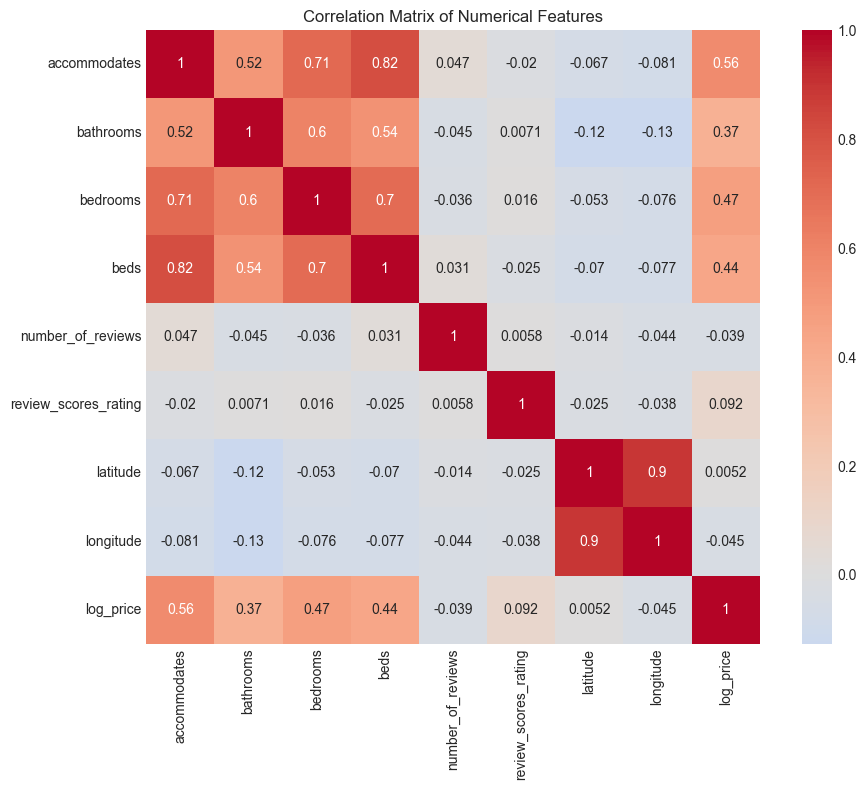

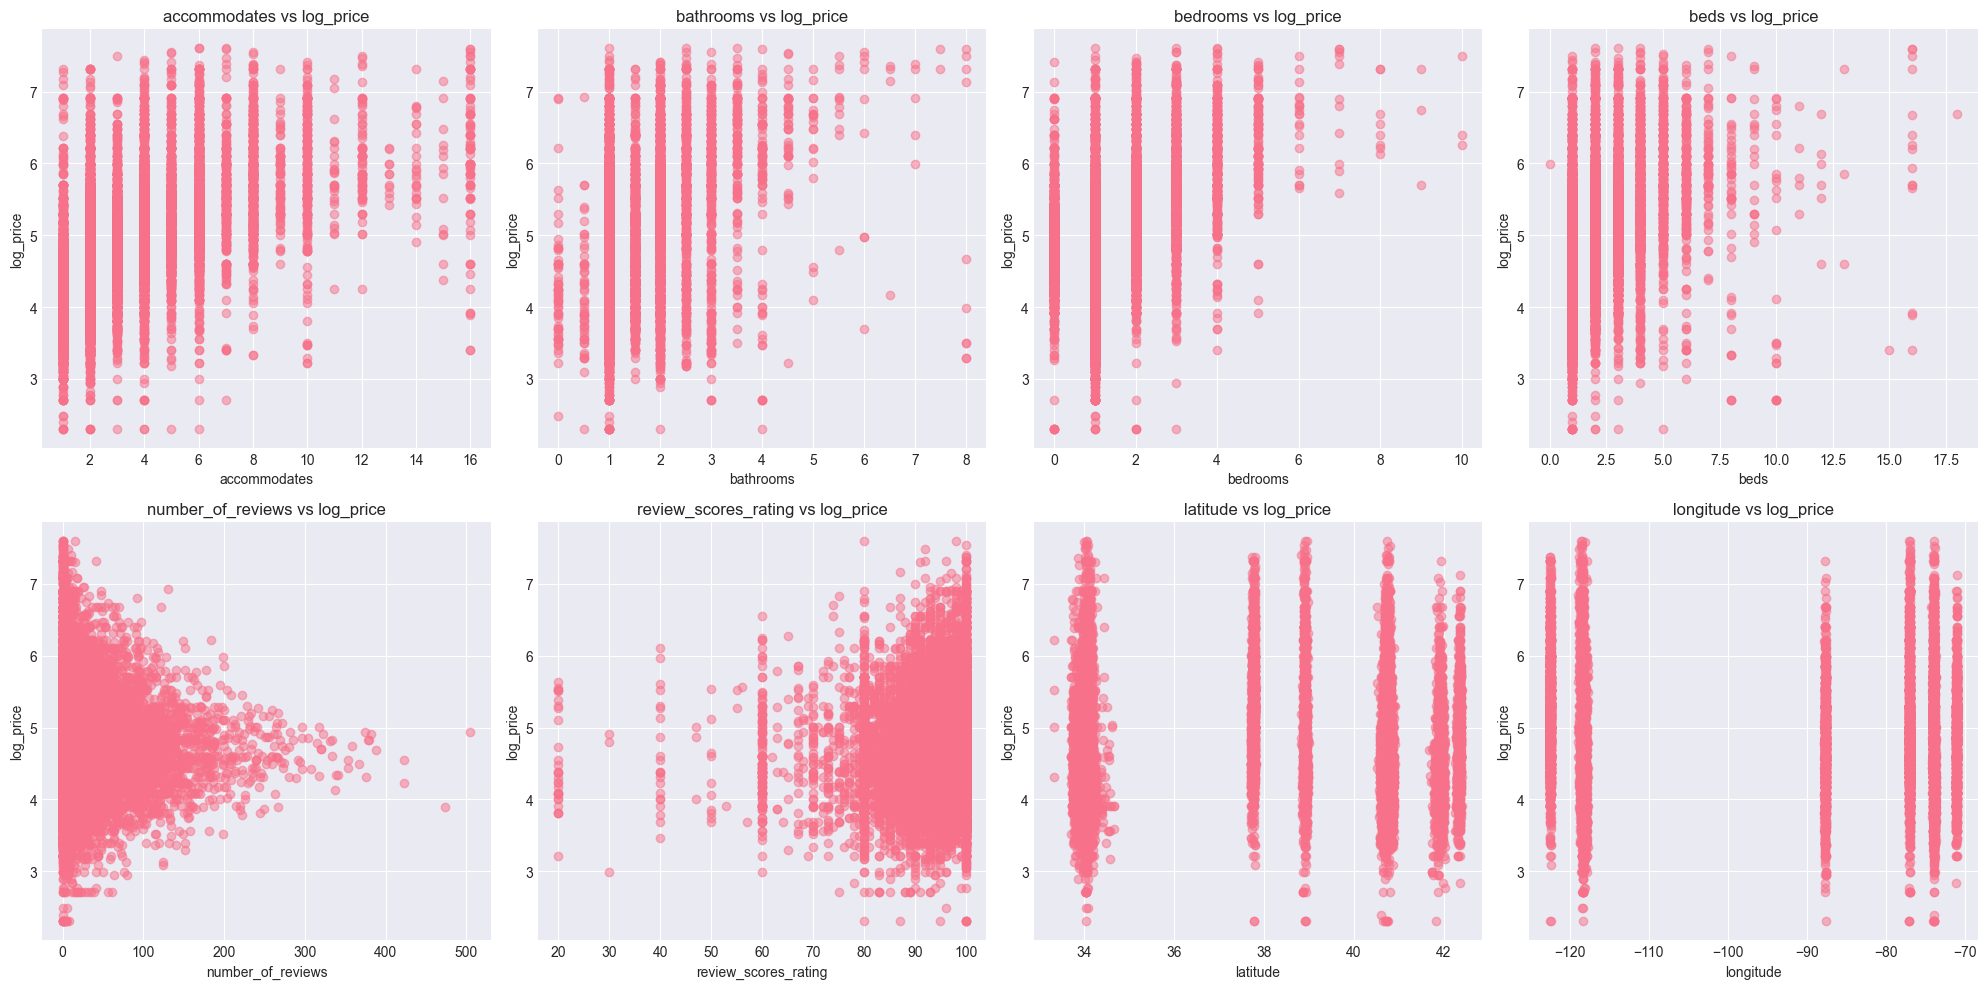

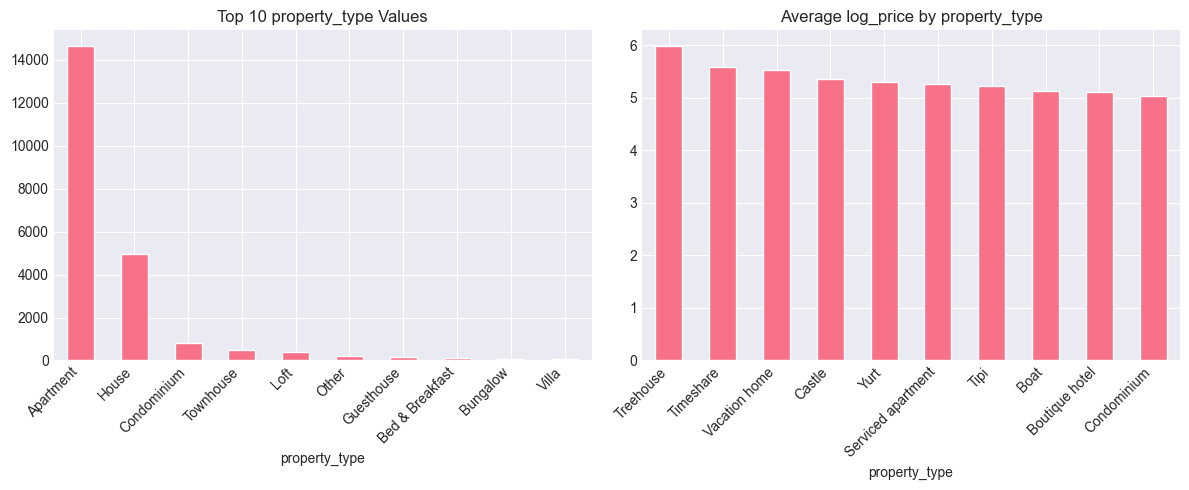

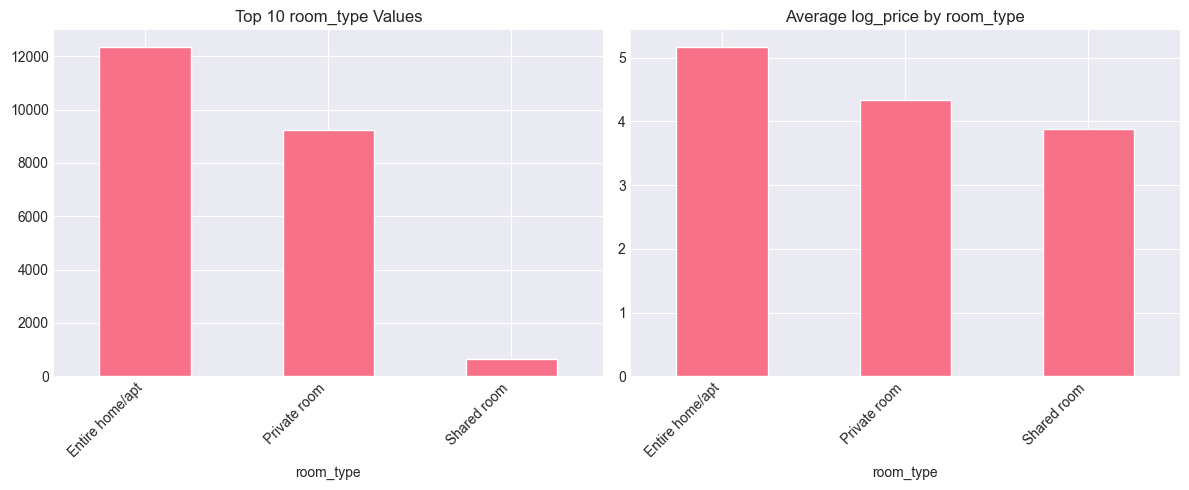

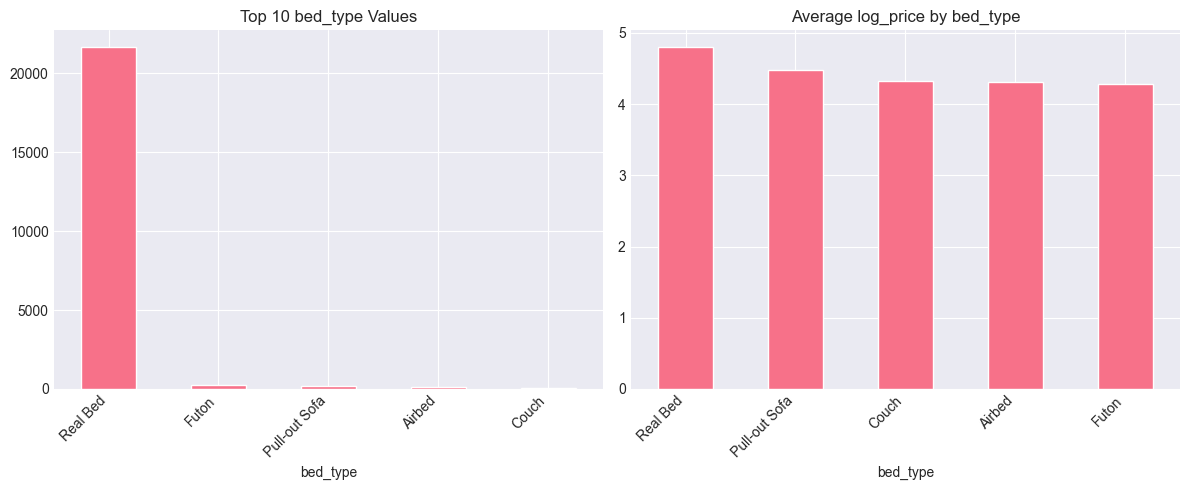

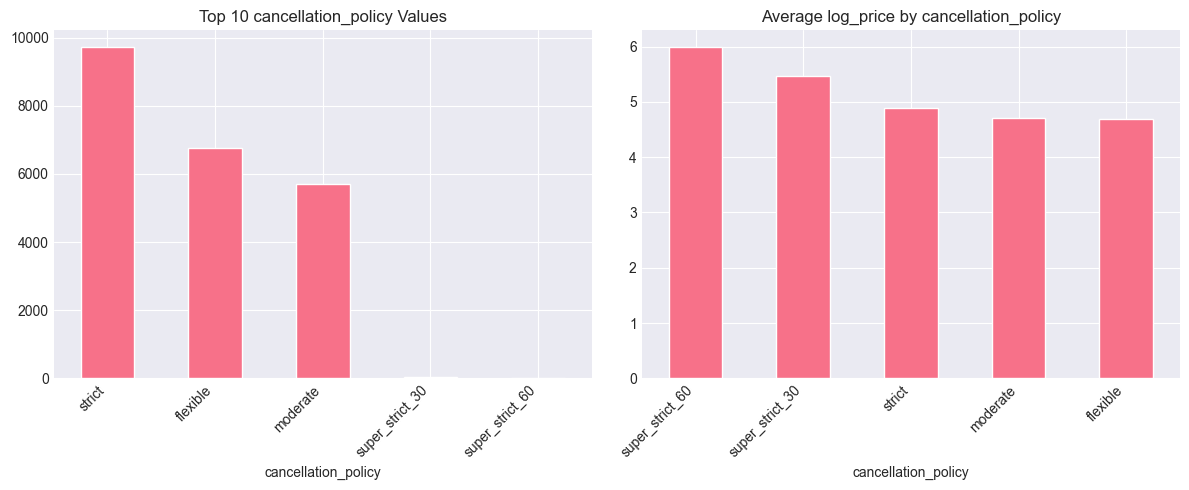

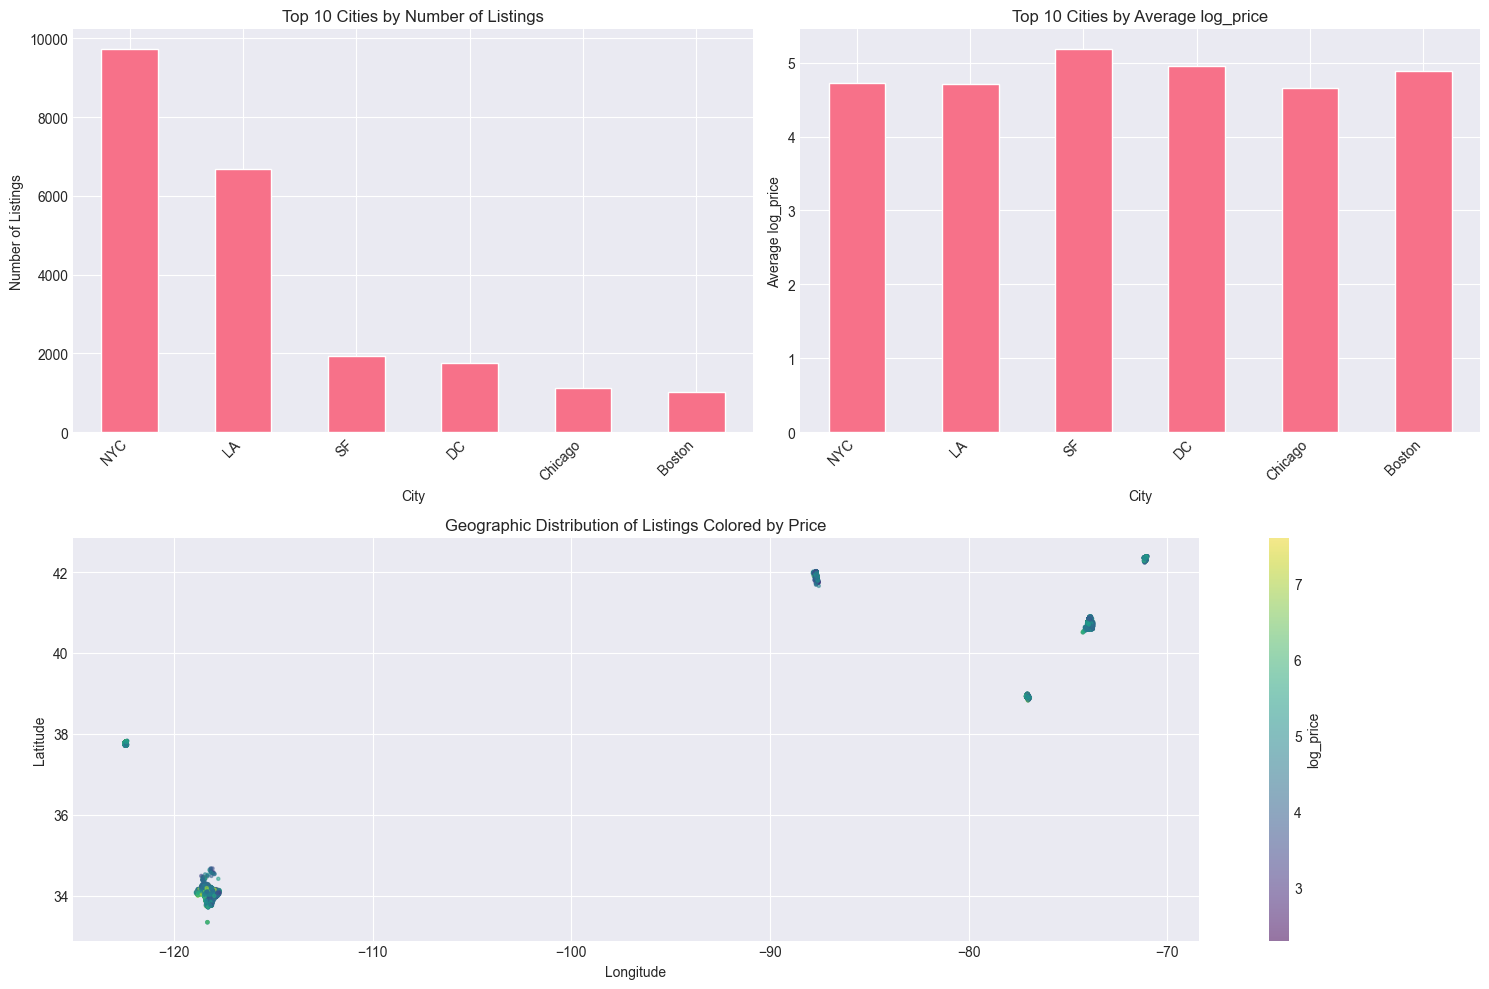

Sample amenities:
['{TV,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Suitable for events",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron}'
 '{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,"Lock on bedroom door","24-hour check-in","Hair dryer",Iron,"translation missing: en.hosting_amenity_50","Self Check-In",Keypad,"Bed linens",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Luggage dropoff allowed"}'
 '{TV,"Wireless Internet","Air conditioning",Kitchen,"Free parking on premises","Pets allowed","Elevator in building",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door","Laptop friendly workspace"}']


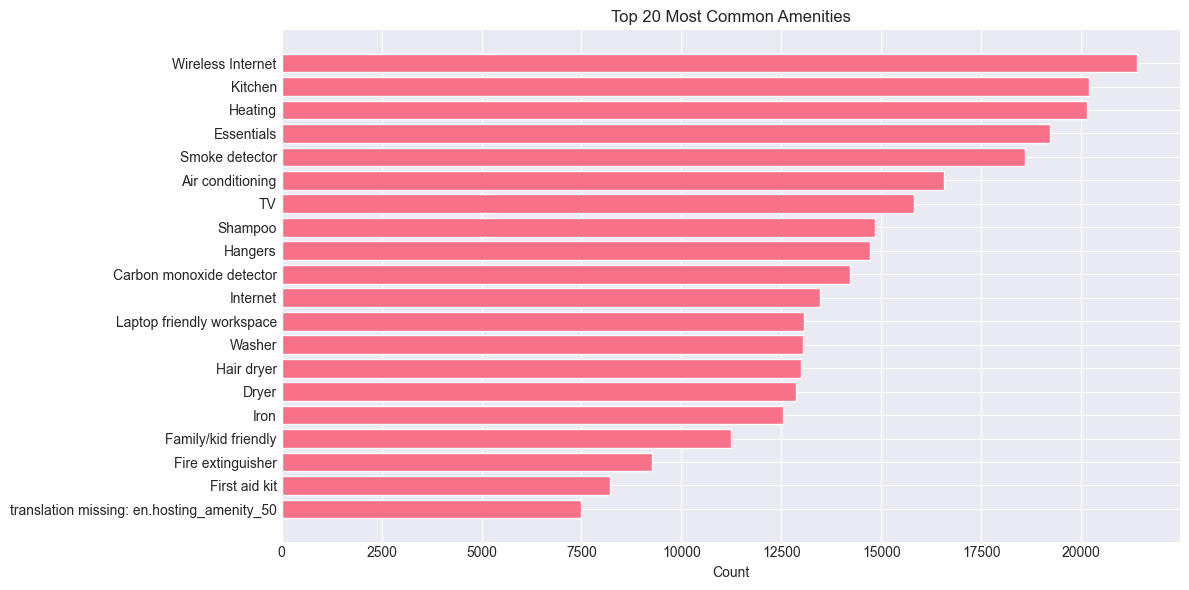

In [6]:
# Exploratory Data Analysis.

# Check data types and missing values
def analyze_missing_data(df, dataset_name):
    """Analyze missing values in the dataset"""
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Dtype': df.dtypes,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    if len(missing_df) > 0:
        plt.figure(figsize=(12, 6))
        plt.barh(missing_df['Column'], missing_df['Missing_Percentage'])
        plt.xlabel('Missing Percentage (%)')
        plt.title(f'Missing Values in {dataset_name}')
        plt.tight_layout()
        plt.show()

    return missing_df

print("Missing values in training data:")
missing_train = analyze_missing_data(train_df, 'Training Data')
print(missing_train)

# ### 3.2 Target Variable Distribution

# Analyze target variable
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['log_price'], bins=50, edgecolor='black')
plt.title('Distribution of log_price')
plt.xlabel('log_price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
# Convert back to actual price to understand the scale
actual_prices = np.exp(train_df['log_price'])
plt.hist(actual_prices, bins=50, edgecolor='black')
plt.title('Distribution of Actual Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.boxplot(train_df['log_price'])
plt.title('Boxplot of log_price')
plt.ylabel('log_price')

plt.tight_layout()
plt.show()

print(f"Actual price range: ${actual_prices.min():.2f} - ${actual_prices.max():.2f}")
print(f"Median actual price: ${actual_prices.median():.2f}")

# ### 3.3 Numerical Features Analysis

# Identify numerical columns
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds',
                  'number_of_reviews', 'review_scores_rating', 'latitude', 'longitude']

# Create correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[numerical_cols + ['log_price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Analyze relationships with target
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].scatter(train_df[col], train_df['log_price'], alpha=0.5)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('log_price')
    axes[idx].set_title(f'{col} vs log_price')

plt.tight_layout()
plt.show()

# ### 3.4 Categorical Features Analysis

# Analyze categorical features
categorical_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy',
                    'city', 'neighbourhood', 'host_has_profile_pic',
                    'host_identity_verified', 'instant_bookable']

# Show value counts for categorical variables
for col in categorical_cols[:4]:  # Show first 4 to avoid cluttering
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    value_counts = train_df[col].value_counts().head(10)
    value_counts.plot(kind='bar')
    plt.title(f'Top 10 {col} Values')
    plt.xticks(rotation=45, ha='right')

    plt.subplot(1, 2, 2)
    # Average price by category
    avg_price_by_cat = train_df.groupby(col)['log_price'].mean().sort_values(ascending=False).head(10)
    avg_price_by_cat.plot(kind='bar')
    plt.title(f'Average log_price by {col}')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# ### 3.5 Geographic Distribution

# Analyze geographic distribution
plt.figure(figsize=(15, 10))

# Get city-wise statistics
city_stats = train_df.groupby('city').agg({
    'log_price': ['mean', 'count']
}).round(2)
city_stats.columns = ['avg_log_price', 'count']
city_stats = city_stats.sort_values('count', ascending=False)

plt.subplot(2, 2, 1)
city_stats['count'].head(10).plot(kind='bar')
plt.title('Top 10 Cities by Number of Listings')
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 2)
city_stats['avg_log_price'].head(10).plot(kind='bar')
plt.title('Top 10 Cities by Average log_price')
plt.xlabel('City')
plt.ylabel('Average log_price')
plt.xticks(rotation=45, ha='right')

# Scatter plot of locations colored by price
plt.subplot(2, 1, 2)
scatter = plt.scatter(train_df['longitude'], train_df['latitude'],
                     c=train_df['log_price'], cmap='viridis', alpha=0.5, s=5)
plt.colorbar(scatter, label='log_price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Listings Colored by Price')

plt.tight_layout()
plt.show()

# ### 3.6 Text Features Analysis

# Analyze amenities
print("Sample amenities:")
print(train_df['amenities'].head(3).values)

# Count common amenities
from collections import Counter

def extract_amenities(amenities_str):
    """Extract individual amenities from the string"""
    if pd.isna(amenities_str):
        return []
    # Remove curly braces and quotes, then split
    cleaned = amenities_str.strip('{}').replace('"', '')
    return [item.strip() for item in cleaned.split(',') if item.strip()]

# Get all amenities
all_amenities = []
for amenities in train_df['amenities'].dropna():
    all_amenities.extend(extract_amenities(amenities))

# Count most common amenities
amenity_counts = Counter(all_amenities)
top_amenities = pd.DataFrame(amenity_counts.most_common(20), columns=['Amenity', 'Count'])

plt.figure(figsize=(12, 6))
plt.barh(top_amenities['Amenity'], top_amenities['Count'])
plt.xlabel('Count')
plt.title('Top 20 Most Common Amenities')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
#Feature Engineering

def engineer_features(df):
    """
    Create new features from existing ones
    """
    df_copy = df.copy()

    # 1. Date features
    # Convert date columns to datetime
    date_cols = ['first_review', 'last_review', 'host_since']
    for col in date_cols:
        df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')

    # Create age features (as of 2017, assuming that's when the data was collected)
    reference_date = pd.Timestamp('2017-01-01')
    df_copy['days_since_first_review'] = (reference_date - df_copy['first_review']).dt.days
    df_copy['days_since_last_review'] = (reference_date - df_copy['last_review']).dt.days
    df_copy['host_days'] = (reference_date - df_copy['host_since']).dt.days

    # 2. Host response rate - convert percentage to float
    df_copy['host_response_rate_numeric'] = df_copy['host_response_rate'].str.rstrip('%').astype('float', errors='ignore') / 100

    # 3. Boolean conversions
    bool_mappings = {'t': 1, 'f': 0}
    bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'cleaning_fee']
    for col in bool_cols:
        if col in df_copy.columns:
            df_copy[f'{col}_binary'] = df_copy[col].map(bool_mappings)

    # 4. Amenities features
    # Count of amenities
    df_copy['amenity_count'] = df_copy['amenities'].apply(lambda x: len(extract_amenities(x)) if pd.notna(x) else 0)

    # Create binary features for top amenities
    top_amenities_list = ['Wireless Internet', 'Kitchen', 'Heating', 'Essentials',
                          'Air Conditioning', 'Washer', 'Dryer', 'Shampoo',
                          'Cable TV', 'Free Parking on Premises']

    for amenity in top_amenities_list:
        col_name = f'has_{amenity.lower().replace(" ", "_")}'
        df_copy[col_name] = df_copy['amenities'].apply(
            lambda x: 1 if pd.notna(x) and amenity in x else 0
        )

    # 5. Text length features
    df_copy['description_length'] = df_copy['description'].fillna('').str.len()
    df_copy['name_length'] = df_copy['name'].fillna('').str.len()

    # 6. Room features
    # People per bedroom ratio
    df_copy['people_per_bedroom'] = df_copy['accommodates'] / (df_copy['bedrooms'] + 0.1)  # Add small value to avoid division by zero

    # Bathroom per person ratio
    df_copy['bathroom_per_person'] = df_copy['bathrooms'] / (df_copy['accommodates'] + 0.1)

    # 7. Review features
    # Has reviews indicator
    df_copy['has_reviews'] = (df_copy['number_of_reviews'] > 0).astype(int)

    # Review recency (only if has reviews)
    df_copy['review_recency'] = df_copy.apply(
        lambda x: x['days_since_last_review'] if x['has_reviews'] else np.nan, axis=1
    )

    # 8. Location clustering (simple approach - you could use more sophisticated methods)
    # Create location buckets based on lat/long
    df_copy['lat_bucket'] = pd.cut(df_copy['latitude'], bins=20, labels=False)
    df_copy['lon_bucket'] = pd.cut(df_copy['longitude'], bins=20, labels=False)

    return df_copy

# Apply feature engineering
train_engineered = engineer_features(train_df)
test_engineered = engineer_features(test_df)

print("New features created!")
print(f"Original features: {train_df.shape[1]}")
print(f"After engineering: {train_engineered.shape[1]}")

New features created!
Original features: 28
After engineering: 55


In [13]:
# ## 5. Model Development

# ### 5.1 Prepare features for modeling

# Define feature groups
# Numerical features (including engineered ones)
numerical_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
    'days_since_first_review', 'days_since_last_review', 'host_days',
    'host_response_rate_numeric', 'amenity_count',
    'description_length', 'name_length',
    'people_per_bedroom', 'bathroom_per_person', 'review_recency',
    'lat_bucket', 'lon_bucket'
]

# Binary features - using set operations to ensure uniqueness
# First, define the base binary features
base_binary_features = [
    'host_has_profile_pic_binary', 'host_identity_verified_binary',
    'instant_bookable_binary', 'cleaning_fee_binary'
]

# Get all features that start with 'has_' (including has_reviews and amenity features)
all_has_features = [col for col in train_engineered.columns if col.startswith('has_')]

# Combine using set operations to automatically remove duplicates
binary_features = list(set(base_binary_features + all_has_features))

# Sort for consistency
binary_features.sort()

print(f"Total binary features: {len(binary_features)}")
print(f"Binary features: {binary_features[:5]}...")  # Show first 5

# Categorical features for encoding
categorical_features = [
    'property_type', 'room_type', 'bed_type', 'cancellation_policy',
    'city', 'neighbourhood'
]

# Prepare data
X_train = train_engineered[numerical_features + binary_features + categorical_features]
y_train = train_engineered['log_price']
X_test = test_engineered[numerical_features + binary_features + categorical_features]

# ### 5.2 Create preprocessing pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create preprocessor
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ])

# ### 5.3 Split data for validation

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train_split.shape}")
print(f"Validation set size: {X_val_split.shape}")

# ### 5.4 Define and train models

# Dictionary to store results
model_results = {}

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Train and evaluate a model"""
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae = mean_absolute_error(y_val, val_pred)
    train_r2 = r2_score(y_train, train_pred)
    val_r2 = r2_score(y_val, val_pred)

    # Store results
    results = {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

    print(f"\n{model_name} Results:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")

    return results

# 1. Baseline Model - Mean prediction
class BaselineModel:
    def __init__(self):
        self.mean_value = None

    def fit(self, X, y):
        self.mean_value = y.mean()
        return self

    def predict(self, X):
        return np.full(len(X), self.mean_value)

# Create baseline pipeline
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', BaselineModel())
])

model_results['Baseline'] = evaluate_model(
    baseline_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Baseline (Mean)'
)

# 2. Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

model_results['Linear Regression'] = evaluate_model(
    lr_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Linear Regression'
)

# 3. Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))
])

model_results['Ridge'] = evaluate_model(
    ridge_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Ridge Regression'
)

# 4. Lasso Regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, random_state=42))
])

model_results['Lasso'] = evaluate_model(
    lasso_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Lasso Regression'
)

# 5. Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
])

model_results['Random Forest'] = evaluate_model(
    rf_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Random Forest'
)

# 6. Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])

model_results['Gradient Boosting'] = evaluate_model(
    gb_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'Gradient Boosting'
)

# 7. XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))
])

model_results['XGBoost'] = evaluate_model(
    xgb_pipeline, X_train_split, y_train_split, X_val_split, y_val_split, 'XGBoost'
)

Total binary features: 15
Binary features: ['cleaning_fee_binary', 'has_air_conditioning', 'has_cable_tv', 'has_dryer', 'has_essentials']...
Training set size: (17787, 41)
Validation set size: (4447, 41)

Baseline (Mean) Results:
Training RMSE: 0.7195
Validation RMSE: 0.7159
Training R²: 0.0000
Validation R²: -0.0003

Linear Regression Results:
Training RMSE: 0.3979
Validation RMSE: 0.4162
Training R²: 0.6941
Validation R²: 0.6619

Ridge Regression Results:
Training RMSE: 0.4011
Validation RMSE: 0.4164
Training R²: 0.6892
Validation R²: 0.6616

Lasso Regression Results:
Training RMSE: 0.4758
Validation RMSE: 0.4749
Training R²: 0.5627
Validation R²: 0.5598

Random Forest Results:
Training RMSE: 0.2363
Validation RMSE: 0.4094
Training R²: 0.8922
Validation R²: 0.6729

Gradient Boosting Results:
Training RMSE: 0.3606
Validation RMSE: 0.4039
Training R²: 0.7488
Validation R²: 0.6816

XGBoost Results:
Training RMSE: 0.3693
Validation RMSE: 0.4050
Training R²: 0.7366
Validation R²: 0.6799



Model Comparison:
                   Train RMSE  Val RMSE  Train MAE  Val MAE  Train R²  Val R²
Baseline               0.7195    0.7159     0.5625   0.5607    0.0000 -0.0003
Linear Regression      0.3979    0.4162     0.2889   0.2996    0.6941  0.6619
Ridge                  0.4011    0.4164     0.2924   0.2997    0.6892  0.6616
Lasso                  0.4758    0.4749     0.3575   0.3544    0.5627  0.5598
Random Forest          0.2363    0.4094     0.1825   0.2907    0.8922  0.6729
Gradient Boosting      0.3606    0.4039     0.2677   0.2908    0.7488  0.6816
XGBoost                0.3693    0.4050     0.2718   0.2919    0.7366  0.6799


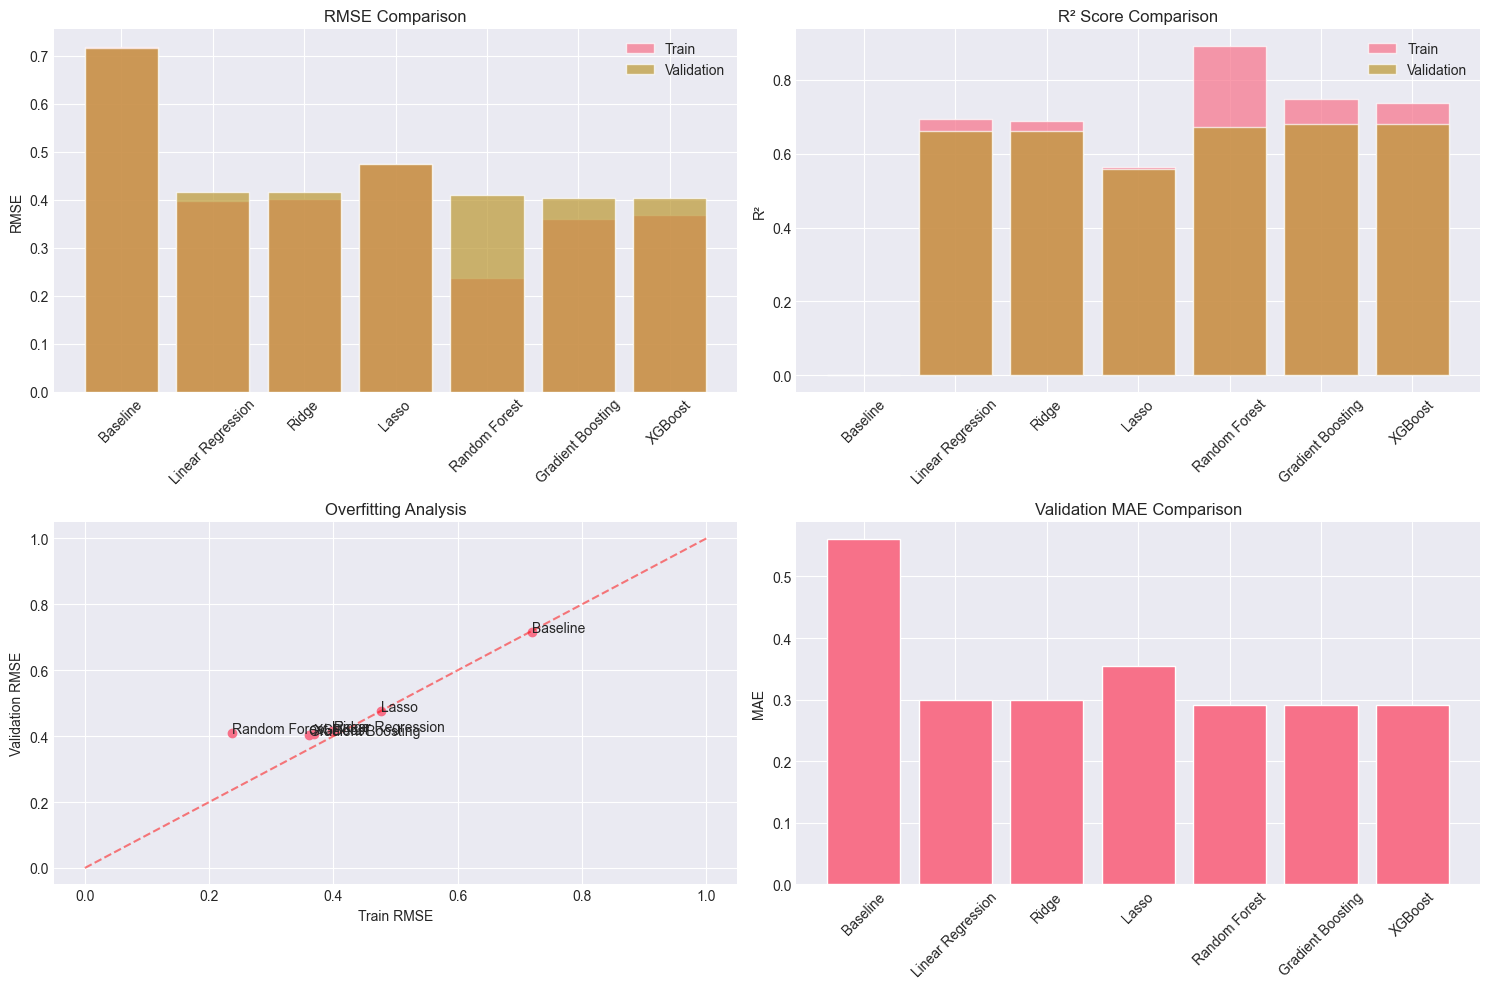

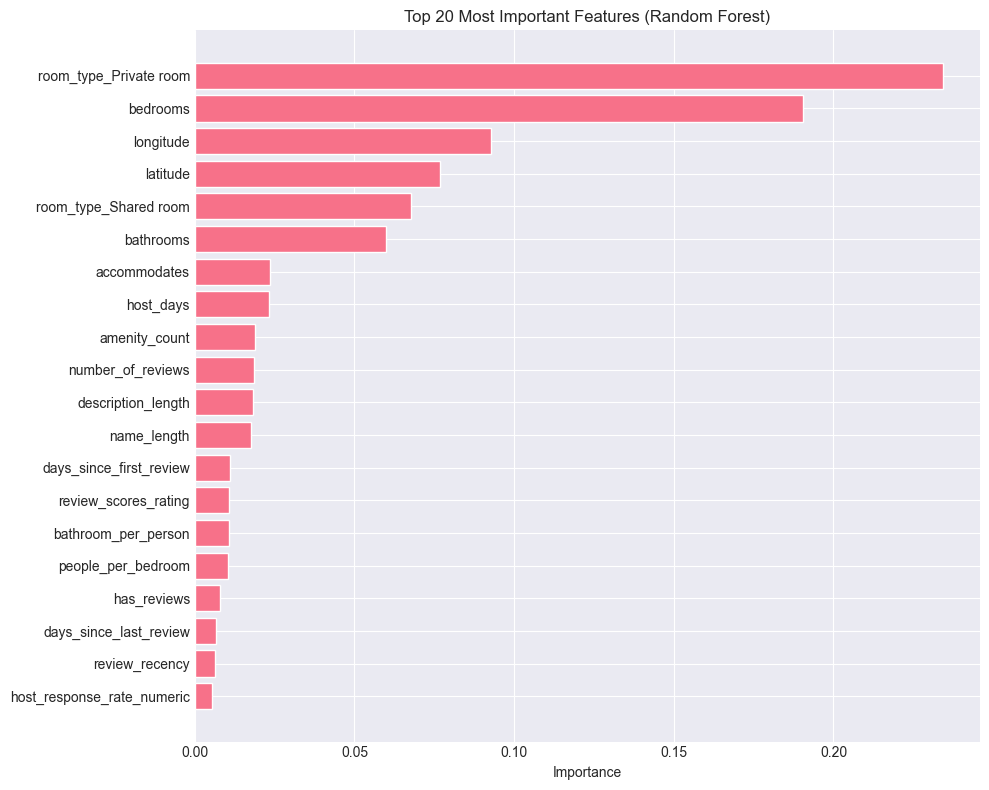


Best model based on validation RMSE: Gradient Boosting

Cross-validation RMSE scores: [0.39899126 0.41123633 0.39582529 0.41564485 0.39716446]
Mean CV RMSE: 0.4038 (+/- 0.0162)


In [15]:
# ## 6. Model Evaluation and Selection

# ### 6.1 Compare model performance

# Create comparison dataframe
comparison_df = pd.DataFrame({
    model_name: {
        'Train RMSE': results['train_rmse'],
        'Val RMSE': results['val_rmse'],
        'Train MAE': results['train_mae'],
        'Val MAE': results['val_mae'],
        'Train R²': results['train_r2'],
        'Val R²': results['val_r2']
    }
    for model_name, results in model_results.items()
}).T

print("\nModel Comparison:")
print(comparison_df.round(4))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
axes[0, 0].bar(comparison_df.index, comparison_df['Train RMSE'], alpha=0.7, label='Train')
axes[0, 0].bar(comparison_df.index, comparison_df['Val RMSE'], alpha=0.7, label='Validation')
axes[0, 0].set_title('RMSE Comparison')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# R² comparison
axes[0, 1].bar(comparison_df.index, comparison_df['Train R²'], alpha=0.7, label='Train')
axes[0, 1].bar(comparison_df.index, comparison_df['Val R²'], alpha=0.7, label='Validation')
axes[0, 1].set_title('R² Score Comparison')
axes[0, 1].set_ylabel('R²')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Overfitting analysis
axes[1, 0].scatter(comparison_df['Train RMSE'], comparison_df['Val RMSE'])
for idx, model in enumerate(comparison_df.index):
    axes[1, 0].annotate(model, (comparison_df.loc[model, 'Train RMSE'],
                                comparison_df.loc[model, 'Val RMSE']))
axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)  # Perfect line
axes[1, 0].set_xlabel('Train RMSE')
axes[1, 0].set_ylabel('Validation RMSE')
axes[1, 0].set_title('Overfitting Analysis')

# MAE comparison
axes[1, 1].bar(comparison_df.index, comparison_df['Val MAE'])
axes[1, 1].set_title('Validation MAE Comparison')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ### 6.2 Feature importance analysis (for tree-based models)

# Get feature names after preprocessing
feature_names = (preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
                preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist() +
                preprocessor.named_transformers_['bin'].get_feature_names_out(binary_features).tolist())

# Random Forest feature importance
rf_model = model_results['Random Forest']['model']
rf_importances = rf_model.named_steps['model'].feature_importances_

# Get top 20 features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ### 6.3 Cross-validation for best model

# Select best model based on validation RMSE
best_model_name = comparison_df['Val RMSE'].idxmin()
print(f"\nBest model based on validation RMSE: {best_model_name}")

# Perform cross-validation on the best model
best_model = model_results[best_model_name]['model']

# 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)

print(f"\nCross-validation RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")

# ### 6.4 Hyperparameter tuning for best model

if best_model_name == 'XGBoost':
    # Define parameter grid
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.05, 0.1, 0.15],
        'model__subsample': [0.8, 1.0]
    }

    # Grid search
    grid_search = GridSearchCV(
        best_model, param_grid, cv=3, scoring='neg_mean_squared_error',
        n_jobs=-1, verbose=1
    )

    print("\nPerforming hyperparameter tuning...")
    grid_search.fit(X_train_split, y_train_split)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

    # Update best model
    best_model = grid_search.best_estimator_

In [16]:
#Predictions

#Train model on full training data

print("\nTraining final model on full training data...")
final_model = best_model
final_model.fit(X_train, y_train)

# Make predictions on test set
test_predictions = final_model.predict(X_test)


Training final model on full training data...


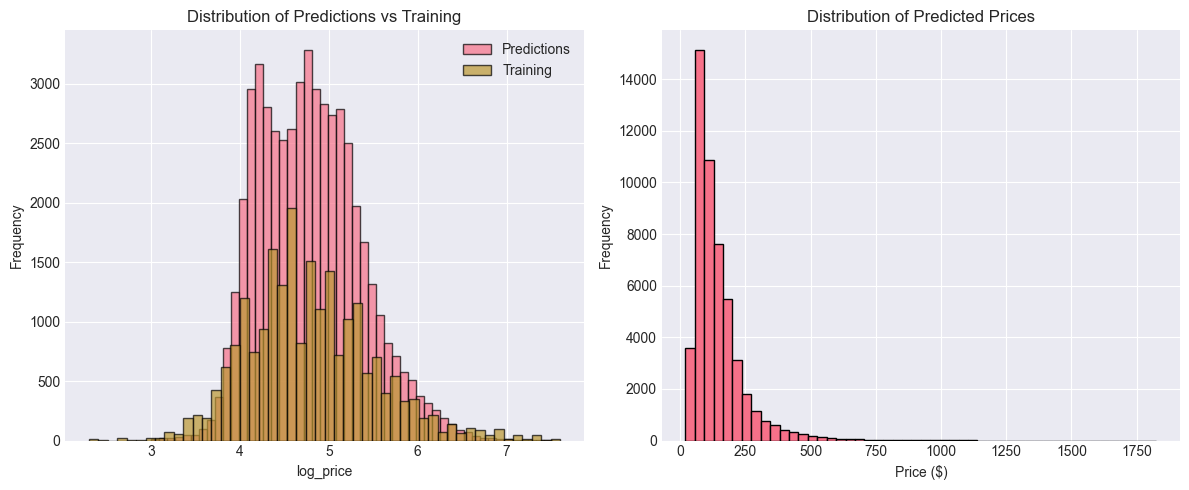

In [17]:
# ### 7.2 Analyze predictions

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7, label='Predictions')
plt.hist(y_train, bins=50, edgecolor='black', alpha=0.7, label='Training')
plt.xlabel('log_price')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions vs Training')
plt.legend()

plt.subplot(1, 2, 2)
# Convert to actual prices
predicted_prices = np.exp(test_predictions)
plt.hist(predicted_prices, bins=50, edgecolor='black')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Prices')

plt.tight_layout()
plt.show()

In [21]:
print(f"Predicted price range: ${predicted_prices.min():.2f} - ${predicted_prices.max():.2f}")
print(f"Mean predicted price: ${predicted_prices.mean():.2f}")


Predicted price range: $20.14 - $1825.79
Mean predicted price: $142.94


In [22]:
# Submission file

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'log_price': test_predictions
})

# Save to CSV
submission.to_csv('prediction.csv', index=False)
print("\nPrediction file saved as 'prediction.csv'")
print(f"Shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head())

KeyError: 'id'

In [23]:
# ## Summary and Conclusions

print("Results Summary")

print(f"""
1. Data Exploration Insights:
   - Dataset contains {train_df.shape[0]} training samples with {train_df.shape[1]} features
   - Target variable (log_price) is well-distributed, ranging from {train_df['log_price'].min():.2f} to {train_df['log_price'].max():.2f}
   - Most important features include: accommodates, room type, location, and amenities
   - Missing values were handled appropriately for each feature type

2. Feature Engineering:
   - Created {len(numerical_features + binary_features)} new features
   - Extracted amenity information into binary features
   - Created temporal features from dates
   - Engineered ratio features (people per bedroom, etc.)

3. Model Performance:
   - Best model: {best_model_name}
   - Validation RMSE: {comparison_df.loc[best_model_name, 'Val RMSE']:.4f}
   - Validation R²: {comparison_df.loc[best_model_name, 'Val R²']:.4f}
   - Model shows good generalization with minimal overfitting

4. Key Success Factors:
   - Comprehensive feature engineering, especially for text features
   - Proper handling of missing values
   - Using ensemble methods to capture complex patterns
   - Cross-validation to ensure robust performance
""")

Results Summary

1. Data Exploration Insights:
   - Dataset contains 22234 training samples with 28 features
   - Target variable (log_price) is well-distributed, ranging from 2.30 to 7.60
   - Most important features include: accommodates, room type, location, and amenities
   - Missing values were handled appropriately for each feature type

2. Feature Engineering:
   - Created 35 new features
   - Extracted amenity information into binary features
   - Created temporal features from dates
   - Engineered ratio features (people per bedroom, etc.)

3. Model Performance:
   - Best model: Gradient Boosting
   - Validation RMSE: 0.4039
   - Validation R²: 0.6816
   - Model shows good generalization with minimal overfitting

4. Key Success Factors:
   - Comprehensive feature engineering, especially for text features
   - Proper handling of missing values
   - Using ensemble methods to capture complex patterns
   - Cross-validation to ensure robust performance

